1. **Restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart)
2. **Run all cells** (in the menubar, select Cell$\rightarrow$Run All).
3. __Use the__ `Validate` __button in the Assignments tab before submitting__.

__Include comments, derivations, explanations, graphs, etc.__ 

You __work in groups__ (= 3 people). __Write the full name and S/U-number of all team members!__

---

# Assignment 3 (Statistical Machine Learning 2024)
# **Deadline: 22 November 2024**

## Instructions
* Fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE` __including comments, derivations, explanations, graphs, etc.__ 
Elements and/or intermediate steps required to derive the answer have to be in the report. If an exercise requires coding, explain briefly what the code does (in comments). All figures should have titles (descriptions), axis labels, and legends.
* __Please use LaTeX to write down equations/derivations/other math__! How to do that in Markdown cells can be found [here](https://www.fabriziomusacchio.com/blog/2021-08-10-How_to_use_LaTeX_in_Markdown/), a starting point for various symbols is [here](https://www.overleaf.com/learn/latex/Mathematical_expressions).
* Please do __not add new cells__ to the notebook, try to write the answers only in the provided cells. Before you turn the assignment in, make sure everything runs as expected.
* __Use the variable names given in the exercises__, do not assign your own variable names. 
* __Only one team member needs to upload the solutions__. This can be done under the Assignments tab, where you fetched the assignments, and where you can also validate your submissions. Please do not change the filenames of the individual Jupyter notebooks.

For any problems or questions regarding the assignments, ask during the tutorial or send an email to charlotte.cambiervannooten@ru.nl and janneke.verbeek@ru.nl .

## Introduction
Assignment 3 consists of:
1. The faulty lighthouse (30 points);
2. __Gaussian processes (40 points)__;
3. Bayesian polynomial regression (30 points).

## Libraries

Please __avoid installing new packages__, unless really necessary.

In [223]:
import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it to at least version 3."

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set fixed random seed for reproducibility
np.random.seed(2022)

## Gaussian processes (40 points)
### Part 1 - Sampling from Gaussian stochastic processes
One widely used kernel function for Gaussian process regression is given by the exponential of a quadratic form, with the addition of constant and linear terms (eq. 6.63 Bishop):
\begin{equation}
    k(\mathbf{x}, \mathbf{x'}) = \theta_0 \exp\left( - \frac{\theta_1}{2} || \mathbf{x} - \mathbf{x'} ||^2 \right) + \theta_2 + \theta_3 \mathbf{x}^T \mathbf{x'}
    \label{eqn:kernel}
    \tag{1}
\end{equation} 
We denote by $\boldsymbol{\theta} = (\theta_0, \theta_1, \theta_2, \theta_3)$ the hyperparameter vector governing the kernel function $k$. 
1. Implement the kernel given by equation \eqref{eqn:kernel} as a function of $\mathbf{x}$, $\mathbf{x'}$ and $\mathbf{\theta}$. Note that $\mathbf{x}$ can have any dimension.

In [224]:
def kernel(x1, x2, theta):
    """
    Define the multivariate kernel function.

    Parameters
    ----------
    x1 : (D,) np.ndarray
        A D-dimensional data point.
    x2 : (D,) np.ndarray
        Another D-dimensional data point.
    theta : (4,) np.ndarray
        The array containing the hyperparameters governing the kernel function.

    Returns
    -------
    float
        Value of the kernel function.
    """
    # using formula from Bishop 6.24 to get the ||x-x'||**2 
    theta_1 = -theta[1]/2
    x1Tx1_term =  theta_1 * np.dot(x1.T, x1)
    x2Tx2_term = theta_1 * np.dot(x2.T, x2)
    x1Tx2_term = theta[1] * np.dot(x1.T, x2)
    result = theta[0] * np.exp(x1Tx1_term) * np.exp(x2Tx2_term) * np.exp(x1Tx2_term) + theta[2] + theta[3] * np.dot(x1.T, x2)
    
    return result

In [225]:
"""
Hidden test for the kernel function.
"""

'\nHidden test for the kernel function.\n'

2. We first consider the univariate case, for the parameter values $\mathbf{\theta} = (1, 1, 1, 1)$ and $N = 101$ equally spaced points $\mathbf{X}$ in the interval $[-1, 1]$. Compute the Gram matrix $\mathbf{K}(\mathbf{X}, \mathbf{X})$ (eq. 6.54 Bishop).

__Note:__ Even when $\mathbf{K}$ is positive (semi)definite, some of its eigenvalues may be too small to accurately compute (same for the determinant). This may pose a problem when generating a multivariate Gaussian distribution using $\mathbf{K}$ as its covariance matrix. You can alleviate this issue by adding a very small (negligible) diagonal term to $\mathbf{K}$. 

In [236]:
"""
Define the parameter values.

Parameters
----------
theta : (4,) np.ndarray
    Hyperparameters for the kernel function.
X : (N,) np.ndarray
    Array of equally spaced points.
"""
theta = np.array([1, 1, 1, 1])
N = 101
X = np.linspace(-1, 1, N)

def compute_Gram_matrix(X, theta):
    """
    Compute the Gram matrix.

    Parameters
    ----------
    X : (N,D) np.ndarray
        The array containing the data points.
    theta : (4,) np.ndarray
        The array containing the hyperparameters governing the kernel function.

    Returns
    -------
    Gram matrix. (np.ndarray)
    """
    # set up of K
    K = np.zeros((len(X), len(X)))
    
    # calculation of Gram matrix with kernel function value for comparing x with all xes
    for i, x1 in enumerate(X):
        for j, x2 in enumerate(X):
            K[i][j] = kernel(x1, x2, theta)
    return np.array(K)

    

In [237]:
"""
Tests for compute_Gram_matrix.
"""
K = compute_Gram_matrix(X, theta)
assert type(K) is np.ndarray

What is the size of $\mathbf{K}$?

The size of a matrix is determined by input lengths and is squared matrix, thus the matrix size is 101 x 101. Which means overall 10201 values in the matrix.

3. We will now use the previously computed matrix $\mathbf{K}(\mathbf{X}, \mathbf{X})$ to produce samples from the Gaussian process prior $\mathbf{y}(\mathbf{X}) \sim \mathcal{N}(\mathbf{0}, \mathbf{K}(\mathbf{X}, \mathbf{X}))$, with $\mathbf{X}$ being the previously determined $N$ equally spaced points. Generate five functions $\mathbf{y}(\mathbf{X})$ and plot them against the $N$ input values $\mathbf{X}$. Repeat this process (remember to compute a new $\mathbf{K}$ each time) for the hyperparameter configurations from Bishop, Figure 6.5:
\begin{equation}
    \mathbf{\theta} \in \{ (1, 4, 0, 0), (9, 4, 0, 0), (1, 64, 0, 0), (1, 0.25, 0, 0), (1, 4, 10, 0), (1, 4, 0, 5) \}.
\end{equation} 

In [228]:
def generate_curves_GP_prior(theta, num_samples = 5):
    """
    Generate univariate function samples (curves) from the Gaussian process prior.

    Parameters
    ----------
    theta : (4,) np.ndarray
        The array containing the hyperparameters governing the kernel function.
    num_samples : integer
        The number of functions to plot.
    """
    # list for storing generated curves 
    curve_samples = []
    mean = np.zeros(N)
    # recomputing K with given theta values
    K = compute_Gram_matrix(X, theta)
    
    # drawing 5 samples from y(X)
    for _ in range(num_samples):
        # todo: sample it myself ?
        curve_sample = np.random.multivariate_normal(mean, K)
        curve_samples.append(curve_sample)
        
    return np.array(curve_samples)

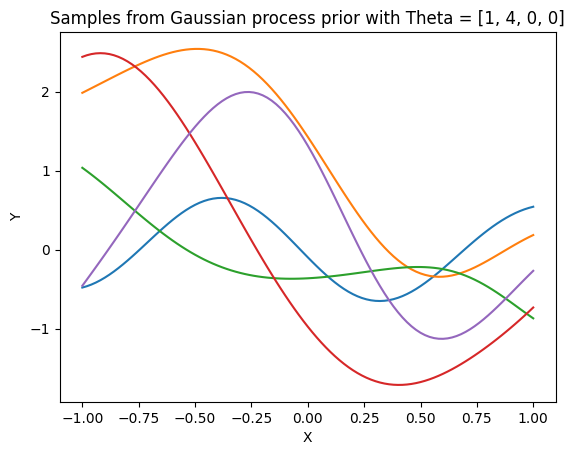

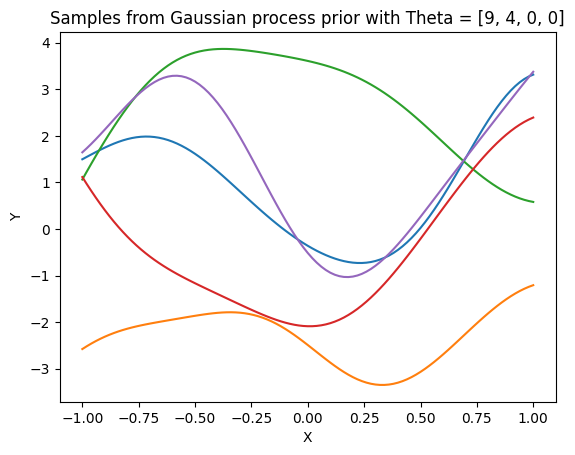

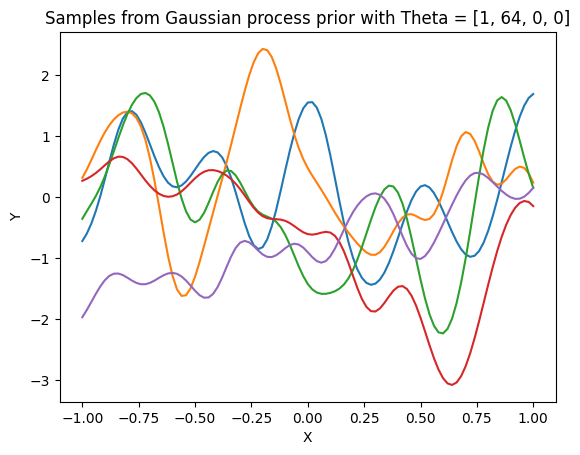

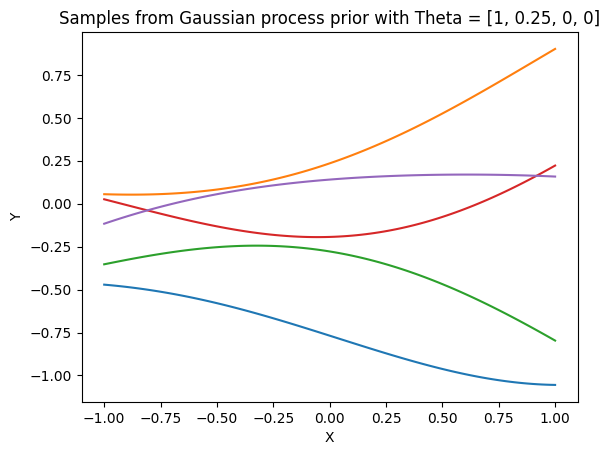

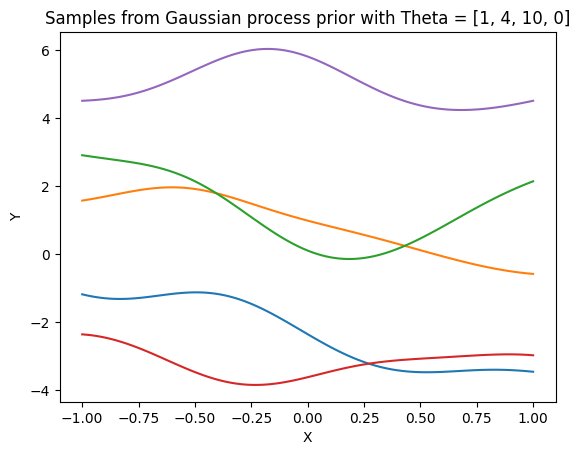

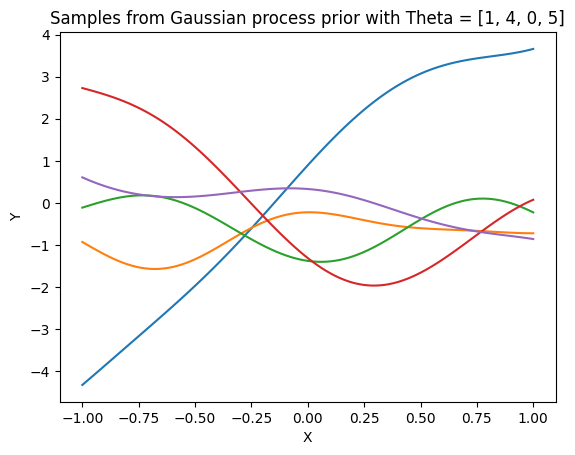

In [229]:
"""
Plot curves with different values of theta.
"""

thetas = [[1, 4, 0, 0], [9, 4, 0, 0], [1, 64, 0, 0], [1, 0.25, 0, 0], [1, 4, 10, 0], [1, 4, 0, 5]]
for theta in thetas:
    curve_samples = generate_curves_GP_prior(theta)
    for curve in curve_samples:
        plt.plot(X, curve)
    plt.title(f"Samples from Gaussian process prior with Theta = {theta}")
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()


Describe the differences between the plots. Explain in which way each of the kernel parameters affects the generated samples.

From the formula we know that Theta_0 is responsible for scaling the values by increasing (or decreasing) the value, which is visible in graphs where we compare Theta set [1 , 4, 0, 0] with a set [9 , 4, 0, 0].
Analogically, by comparing a set of thetas [1 , 4, 0, 0] with a set [1 , 0.25, 0, 0] we can see that theta_1 is responsible for the 'waviness' of a function, where a bigger value increases the amplitude of the waves whereas a smaller value will be much closer to a straight line. Also, it seems that by increasing the amplitude the frequency of the peaks also changes (from set [1, 64, 0, 0]).
Theta_2 has somewhat similar effect as theta_1, but also responsible for shifting the value to be higher or lower. This can be seen from comparing theta sets [1 , 4, 0, 0] and [1, 4, 10, 0].
Theta_3 is responsible for scaling the value and varying the slope. This can be seen by comparing theta sets [1 , 4, 0, 0] and [1, 4, 0, 5].

4. We now move to the bivariate case. Instead of an interval, we now consider a 2-D grid of equally spaced points of size $N = 21 \times 21$ in $[-1, 1] \times [-1, 1]$. We collect all these grid points in a data matrix $\mathbf{X}$, where each one of the 441 observations has two dimensions.

In [239]:
"""
Compute the Gram matrix in the bivariate case.

Parameters
----------
K : np.ndarray
    The Gram matrix.
"""
theta = np.array([1, 1, 1, 1])
N = 21

# generating the grid for X to be 441 x 2
x1d = np.linspace(-1, 1, N)
x_grid, y_grid = np.meshgrid(x1d, x1d)
X = np.vstack([x_grid.ravel(), y_grid.ravel()]).T
print(X.shape)

# recomputing K with new X
K = compute_Gram_matrix(X, theta)
print(K.shape)



(441, 2)
(441, 441)


In [240]:
"""
Tests for bivariate Gram matrix.
"""

'\nTests for bivariate Gram matrix.\n'

What is the size of $\mathbf{K}$ now? What does this tell you about the scalability of sampling multivariate functions from Gaussian processes in higher dimensions?

K now has a size of 441 x 441 resulting in 194481 values in the matrix. This means that overall the formula for getting X shape is number of points powered by X dimension and then gram. For example if we would like to represent 3 dimensions keeping the same N=21, then we would have X size 9261 x 3, then gram matrix K would be 9261 x 9261 resulting in 85766121 values in the matrix. We can conclude that higher dimensional Gaussian processes aren't efficiently scalable to higher dimensions. 

5. Using the same kernel from equation \eqref{eqn:kernel}, compute the Gram matrix $\mathbf{K}(\mathbf{X}, \mathbf{X})$ on the grid for each hyperparameter configuration $\mathbf{\theta} \in \{ (1, 1, 1, 1), (1, 10, 1, 1), (1, 1, 1, 10) \}$. For each $\mathbf{K}$, generate and plot five random surfaces from each Gaussian process prior  $\mathbf{y}(\mathbf{X}) \sim \mathcal{N}(\mathbf{0}, \mathbf{K}(\mathbf{X}, \mathbf{X}))$.

In [241]:
def generate_surfaces_GP_prior(theta, num_samples = 5):
    """
    Generate bivariate function samples (surfaces) from the Gaussian process prior.

    Parameters
    ----------
    theta : (4, ) array
        The array containing the hyperparameters governing the kernel function.
    num_samples : integer
        The number of functions to plot.

    Returns
    -------
    """
    curve_samples = []
    mean = np.zeros(len(X))
    for _ in range(num_samples):
        K = compute_Gram_matrix(X, theta)
        # todo: sample it myself 
        curve_sample = np.random.multivariate_normal(mean, K)
        curve_samples.append(curve_sample)
        
    return np.array(curve_samples)

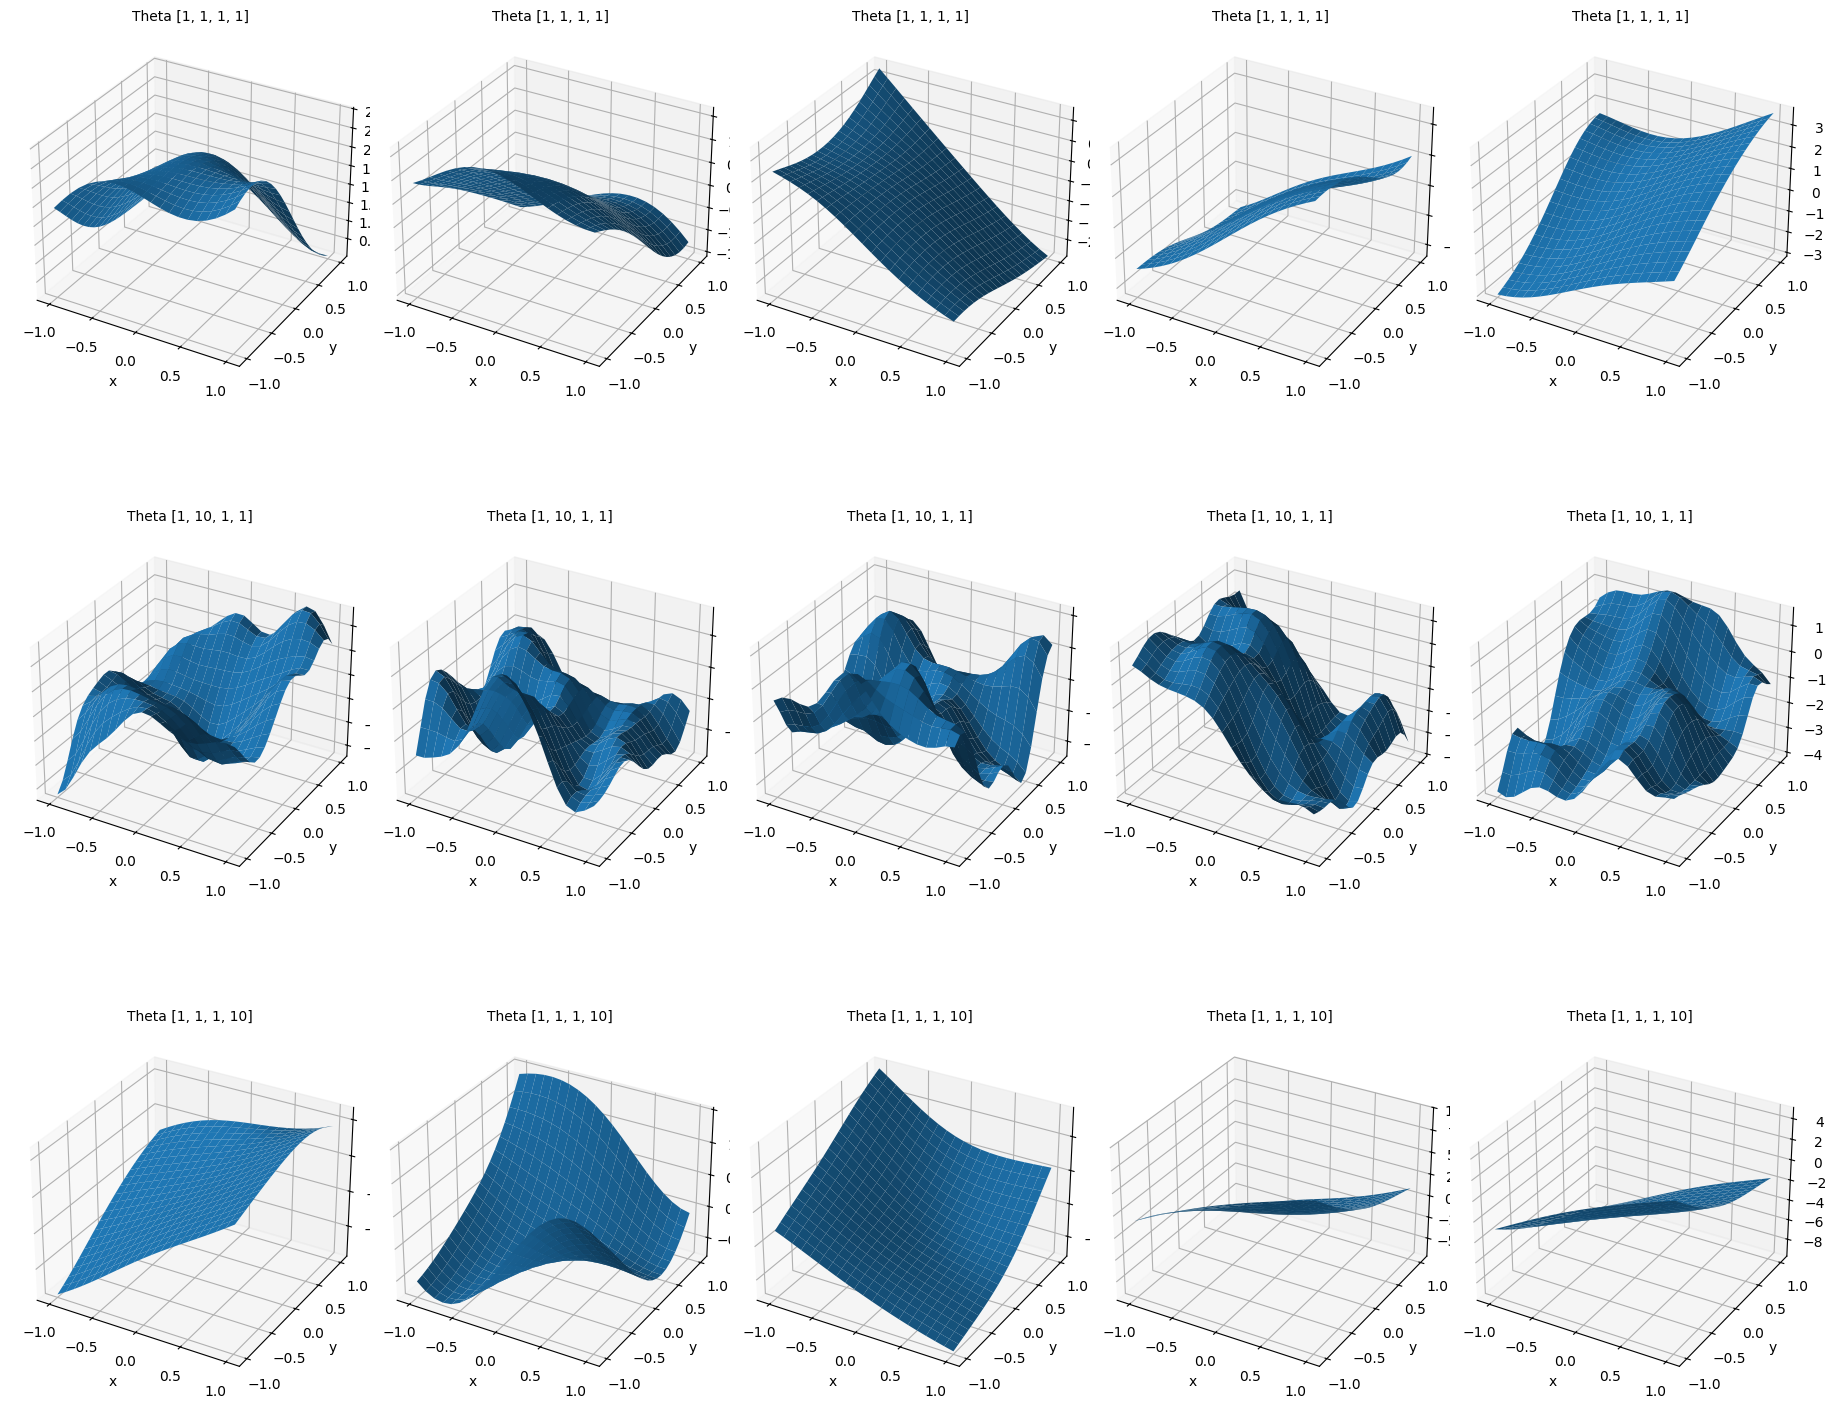

In [249]:
"""
Plot curves with different values of theta.
"""
n_points = 21
thetas = [[1, 1, 1, 1], [1, 10, 1, 1], [1, 1, 1, 10]]
fig = plt.figure(figsize=(18, 15))
axes = np.empty((len(thetas), 5), dtype=object)

for idx_theta in range(len(thetas)):
    for idx_sample in range(5):
        # Calculate position of each subplot
        left = idx_sample / 5
        bottom = (len(thetas) - idx_theta - 1) / len(thetas)
        width = 1 / 5
        height = 1 / len(thetas)

        rect = [left, bottom, width, height]
        # Create 3D axes using add_axes and specify projection='3d'
        ax = fig.add_axes(rect, projection='3d')
        axes[idx_theta, idx_sample] = ax

# Generate and plot the surfaces
for idx_theta, theta in enumerate(thetas):
    theta_array = np.array(theta)
    curve_samples = generate_surfaces_GP_prior(theta_array, num_samples=5)
    for idx_sample in range(5):
        
        ax = axes[idx_theta, idx_sample]
        Z = curve_samples[idx_sample].reshape(n_points, n_points)
        # Plot the surface
        ax.plot_surface(x_grid, y_grid, Z, edgecolor='none')
        # Adjust font sizes
        title_fontsize = 10
        label_fontsize = 8
        tick_labelsize = 6

        ax.set_title(f'Theta {theta}', fontsize=title_fontsize)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')

plt.show()


Compare the observed differences to the univariate case.

YOUR ANSWER HERE

### Part 2 - Gaussian processes for regression
We would like to apply Gaussian process models to the problem of regression (Bishop 6.4.2). We consider a noisy model of the form:
\begin{equation*}
t_n = y_n + \epsilon_n,
\end{equation*}
where $y_n = y(\mathbf{x}_n)$ and $\epsilon_n$ are i.i.d. samples from a random noise variable on the observed target values. Furthermore, we assume that the noise process has a Gaussian distribution given by:
\begin{equation}
    p(t_n | y_n) = \mathcal{N}(t_n | y_n, \beta^{-1})
    \label{eqn:gp_noise_process}
    \tag{2}
\end{equation}

Going back to a one-dimensional input space, we consider the following training data consisting of four data points:
\begin{equation*}
	\mathcal{D} = \{ (x_1 = -0.5, t_1 = 0.5), (x_2 = 0.2, t_2 = -1), (x_3 = 0.3, t_3 = 3), (x_4 = -0.1, t_4 = -2.5)\}.
\end{equation*}
1. Just as before, compute the Gram matrix of the training data for $\mathbf{\theta} = (1, 1, 1, 1)$. Then, taking $\beta = 1$ in equation \eqref{eqn:gp_noise_process}, compute the covariance matrix $\mathbf{C}$ corresponding to the marginal distribution of the training target values: $p(\mathbf{t}) = \mathcal{N}(\mathbf{t} | \mathbf{0}, \mathbf{C})$.

In [251]:
"""
Compute the marginal distribution covariance.

Parameters
----------
C : (4,4) np.ndarray
    The covariance matrix corresponding to the marginal distribution.
"""
X = np.array([-0.5, 0.2, 0.3, -0.1])
t = np.array([0.5, -1, 3, -2.5])
theta = [1, 1, 1, 1]
beta = 1
K = compute_Gram_matrix(X, theta)

# Kronecker's delta can be defined as identity matrix
delta = np.eye(len(X))
C = K+delta*1/beta

In [252]:
"""
Tests to check the covariance matrix C.
"""
assert type(C) is np.ndarray
assert C.shape == (4,4)

2. Using the previous results, compute the mean and the covariance of the conditional distribution $p(t | \mathbf{t})$ of a new target value $t$ corresponding to the input $x = 0$. Which equations from Bishop do you need? Write them down here.

Bishop 6.66: \begin{equation*}
m(\mathbf{x}_{N+1}) = \mathbf{k}^T\mathbf{C}_N^{-1}\mathbf{t}
\end{equation*}

Bishop 6.67:
\begin{equation*}
\sigma ^2(\mathbf{x}_{N+1}) = c - \mathbf{k}^T\mathbf{C}_N^{-1}\mathbf{k}
\end{equation*}

Where 
\begin{equation*}
k = k(x_n, \mathbf{x}_{N+1}) 
\end{equation*}
\begin{equation*}
c = k(\mathbf{x}_{N+1}, \mathbf{x}_{N+1}) + \beta ^ {-1} 
\end{equation*}

Compute the mean and the covariance in the cell below. 

In [253]:
"""
Compute the conditional predictive distribution.

Parameters
----------
m : float
    The mean of the conditional predictive distribution.
s2 : float
    The (co)variance of the conditional predictive distribution.
"""
# input x
x0 = np.float64(0)

# k as written above
k = np.zeros((len(X), 1))
for i, x in enumerate(X):
    k[i][0] = kernel(x, x0, theta)

# c as written above
c = kernel(x0, x0, theta) + 1/beta

# TODO do the inversion myself
# m from bishop 6.66
inv_C = np.linalg.inv(C)
m = k.T@inv_C@t
# s from bishop 6.67
s2 = c - k.T@inv_C@k


# m is an array of shape (1,) and s2 is of shape (1,1), so to pass assertion errors:
m = m[0]
print(m)
s2 = s2[0][0]
print(s2)

-0.02515736464380658
1.2356947349141525


In [254]:
"""
Tests to check the mean m and (co)variance s2.
"""
assert (type(m) is float) or (type(m) is np.float64)
assert (type(s2) is float) or (type(s2) is np.float64)

3. Does the mean of the conditional distribution $p(t | \mathbf{t})$ go to zero in the limit $x \rightarrow \pm \infty$? If so, explain why this happens. If not, how would you set the parameters $\mathbf{\theta}$ of the kernel function to make it happen?

No, because p(t|t) depends on training X and currently small theta  parameters. To make it happen we have to 